# Imports 

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Define device for torch
use_cuda = True
print("CUDA is available:", torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA is available: True


# Load Dataset
WELFake from HuggingFace

In [3]:
from datasets import load_dataset

stylo_dataset = load_dataset("lelexuanzz/WELFake_stylo_feats")
print(stylo_dataset)

vector_dataset = load_dataset("Paulozs/WELFake_embeddings")
print(vector_dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'has_quotes', 'has_url', 'percent_uppercase', 'frequency_punctuation', 'percent_whitespace', 'frequency_words_length_15', 'frequency_words_length_14', 'frequency_words_length_12', 'frequency_words_length_11', 'avg_sentence_length', 'has_1_to_3_urls', 'has_4_to_6_urls', 'has_more_than_6_urls', 'num_exclamations', 'num_questions', 'avg_word_length', 'lexical_diversity', 'proportion_stopwords'],
        num_rows: 62592
    })
})
DatasetDict({
    train: Dataset({
        features: ['title', 'text', 'label', 'roberta_embedding', 'bow_embedding', 'tfidf_embedding', 'w2v_embedding'],
        num_rows: 62592
    })
})


## Concat dataset (stylo and vectors)

RFE and roberta embeddings

In [4]:
#convert dataset to pandas for easier implementation with sklearn

stylo_df = stylo_dataset["train"].to_pandas()
vector_df = vector_dataset["train"].to_pandas()

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

rfe_top_features = ['has_url', 'percent_uppercase', 'frequency_punctuation', 'percent_whitespace', 'avg_sentence_length', 'num_exclamations', 'num_questions', 'avg_word_length', 'lexical_diversity', 'proportion_stopwords']

seed = 45

y = stylo_df["label"]
x_stylo = stylo_df[rfe_top_features]
x_vector = np.stack(vector_df['roberta_embedding'])
x_combined = np.concatenate([x_stylo, x_vector], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x_combined, y, test_size=0.2, random_state=seed)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

display(x_train_scaled)
display(y_train)


array([[ 0.78498185, -0.29768779,  0.31235261, ..., -0.20638959,
        -0.78492564, -0.13804899],
       [ 0.78498185, -0.38732025, -0.30637509, ..., -0.5412879 ,
         1.15664994,  0.91132215],
       [-1.27391481, -0.6971038 , -0.27594586, ..., -1.27256518,
         0.51137257,  0.61518937],
       ...,
       [ 0.78498185,  2.99365539, -0.46866433, ..., -0.72858553,
         0.60717848,  0.5336511 ],
       [ 0.78498185, -0.60490902,  0.55578646, ...,  0.50906639,
        -0.77225551,  0.20998251],
       [-1.27391481,  0.11788822, -0.14408586, ..., -0.93531617,
        -0.56456013, -0.91099534]])

6312     1
1575     1
34150    0
20440    0
49987    0
        ..
12895    1
60960    1
6012     1
6558     0
56267    1
Name: label, Length: 50073, dtype: int64

# Ensemble

## Boosting

### XGBoost

In [6]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb


param_dist = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8]  
}


xgboost_model = xgb.XGBClassifier(random_state=seed, use_label_encoder=False, eval_metric='auc')

xgboost_model_rs = RandomizedSearchCV(xgboost_model, 
                                      param_distributions=param_dist,
                                      n_iter=10,
                                      cv=5,
                                      n_jobs=-1,
                                      scoring='roc_auc',
                                      verbose=1)

xgboost_model_rs.fit(x_train_scaled, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rat...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=45, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8],
                                        'learning_rate': [0.01, 0.1],
                                        'max_depth': [3, 5],
                                        'n_estimators': [100, 200],
                                        'subsample': [0.8]},
                   scoring='roc_auc', verbose=1)

In [7]:
xgboost_model_best = xgboost_model_rs.best_estimator_

print('Best hyperparameters:',  xgboost_model_rs.best_params_)

y_pred = xgboost_model_best.predict(x_test_scaled)


Best hyperparameters: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.8}


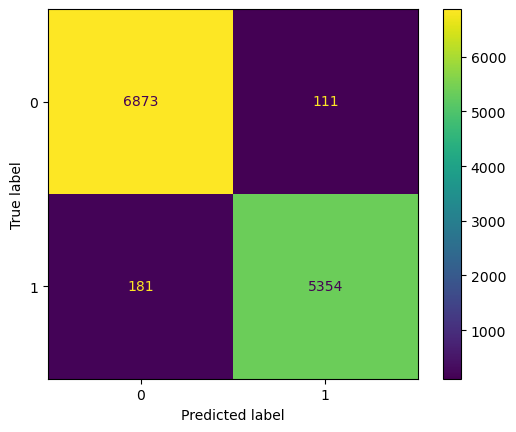

In [8]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, f1_score
# Generate predictions with the best model
y_pred = xgboost_model_best.predict(x_test_scaled)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [9]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1_score:", f1)

Accuracy: 0.9766754533109673
Precision: 0.9796889295516926
Recall: 0.9672990063233966
F1_score: 0.9734545454545455


## Voting

In [34]:
# Separate x_test
x_stylo_test = x_test[:, :10]
x_vector_test = x_test[:, 10:]

In [35]:
# use best few LR and RF models
import pickle
#LR - roBerta
lr_roberta = pickle.load(open('../lr/models/iter4_rf_roberta', 'rb'))

#rf - rfe? hm
rf_rfe = pickle.load(open('models/iter2_rf_rfe', 'rb'))

#rf - roberta
rf_roberta = pickle.load(open('models/iter4_rf_roberta', 'rb'))

In [36]:
import statistics as st

pred1 = lr_roberta.predict(x_vector_test)
pred2 = rf_rfe.predict(x_stylo_test)
pred3 = rf_roberta.predict(x_vector_test)

#final prediction
final_pred = np.array([])
for i in range(0,len(x_test)):
    final_pred = np.append(final_pred, st.mode([pred1[i], pred2[i], pred3[i]]))

print(final_pred)

[0. 0. 0. ... 1. 0. 0.]


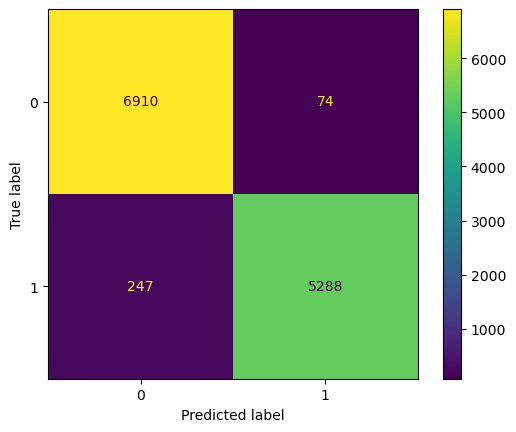

In [37]:
# Create the confusion matrix
cm = confusion_matrix(y_test, final_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [38]:
accuracy = accuracy_score(y_test, final_pred)
precision = precision_score(y_test, final_pred)
recall = recall_score(y_test, final_pred)
f1 = f1_score(y_test, final_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1_score:", f1)

Accuracy: 0.9743589743589743
Precision: 0.9861991794106677
Recall: 0.9553748870822042
F1_score: 0.9705423511058091


## Stacking

Manual stacking since I am using trained models

In [39]:
# Separate x_train
x_stylo_train = x_train[:, :10]
x_vector_train = x_train[:, 10:]

In [40]:
lr_roberta_pred = lr_roberta.predict(x_vector_train)
rf_rfe_pred = rf_rfe.predict(x_stylo_train)
rf_roberta_pred = rf_roberta.predict(x_vector_train)

In [41]:
from sklearn.linear_model import LogisticRegression

stacked_preds = np.column_stack((lr_roberta_pred, rf_rfe_pred, rf_roberta_pred))

meta_model = LogisticRegression()
meta_model.fit(stacked_preds, y_train)


LogisticRegression()

In [42]:
lr_roberta_pred_test = lr_roberta.predict(x_vector_test)
rf_rfe_pred_test = rf_rfe.predict(x_stylo_test)
rf_roberta_pred_test = rf_roberta.predict(x_vector_test)

stacked_test_preds = np.column_stack((lr_roberta_pred_test, rf_rfe_pred_test, rf_roberta_pred_test))

final_pred = meta_model.predict(stacked_test_preds)

In [43]:
accuracy = accuracy_score(y_test, final_pred)
precision = precision_score(y_test, final_pred)
recall = recall_score(y_test, final_pred)
f1 = f1_score(y_test, final_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1_score:", f1)

Accuracy: 0.9535106637910377
Precision: 0.93886230728336
Recall: 0.9571815718157182
F1_score: 0.9479334406870639


## Results on test set

## Boosting

In [15]:
stylo_test_dataset = load_dataset("lelexuanzz/Gossipcop_Politifact_Test_Stylo")
print(stylo_test_dataset)
vector_test_dataset = load_dataset("lelexuanzz/Gossipcop_Politifact_Test")
print(vector_test_dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'has_quotes', 'has_url', 'percent_uppercase', 'frequency_punctuation', 'percent_whitespace', 'frequency_words_length_15', 'frequency_words_length_14', 'frequency_words_length_12', 'frequency_words_length_11', 'avg_sentence_length', 'has_1_to_3_urls', 'has_4_to_6_urls', 'has_more_than_6_urls', 'num_exclamations', 'num_questions', 'avg_word_length', 'lexical_diversity', 'proportion_stopwords'],
        num_rows: 6900
    })
})
DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'tfidf_embedding', 'bow_embedding', 'w2v_embedding', 'roberta_embedding'],
        num_rows: 6900
    })
})


In [16]:
stylo_test_df = stylo_test_dataset["train"].to_pandas()
vector_test_df = vector_test_dataset["train"].to_pandas()


y_test_set = stylo_test_df["label"]
x_stylo_test_set = stylo_test_df[rfe_top_features]
x_vector_test_set = np.stack(vector_test_df["roberta_embedding"])
x_test_set_combined = np.concatenate([x_stylo_test_set, x_vector_test_set], axis=1)

x_test_set_combined_scaled = scaler.fit_transform(x_test_set_combined)

In [17]:
y_test_pred = xgboost_model_best.predict(x_test_set_combined_scaled)

accuracy = accuracy_score(y_test_set, y_test_pred)
precision = precision_score(y_test_set, y_test_pred)
recall = recall_score(y_test_set, y_test_pred)
f1 = f1_score(y_test_set, y_test_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1_score:", f1)

Accuracy: 0.6053623188405797
Precision: 0.4150369404606693
Recall: 0.4095197255574614
F1_score: 0.4122598748111375


## Voting

In [44]:
pred1 = lr_roberta.predict(x_vector_test_set)
pred2 = rf_rfe.predict(x_stylo_test_set)
pred3 = rf_roberta.predict(x_vector_test_set)

#final prediction
final_pred = np.array([])
for i in range(0,len(x_stylo_test_set)):
    final_pred = np.append(final_pred, st.mode([pred1[i], pred2[i], pred3[i]]))

print(final_pred)

[1. 1. 0. ... 0. 0. 1.]


In [45]:
accuracy = accuracy_score(y_test_set, final_pred)
precision = precision_score(y_test_set, final_pred)
recall = recall_score(y_test_set, final_pred)
f1 = f1_score(y_test_set, final_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1_score:", f1)

Accuracy: 0.5730434782608695
Precision: 0.4125854214123007
Recall: 0.6213550600343053
F1_score: 0.4958932238193019


## Stacking

In [46]:
from sklearn.linear_model import LogisticRegression

stacked_test_preds = np.column_stack((pred1, pred2, pred3))

final_pred = meta_model.predict(stacked_test_preds)


In [47]:
accuracy = accuracy_score(y_test_set, final_pred)
precision = precision_score(y_test_set, final_pred)
recall = recall_score(y_test_set, final_pred)
f1 = f1_score(y_test_set, final_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1_score:", f1)

Accuracy: 0.5668115942028985
Precision: 0.4161347970385499
Recall: 0.6989708404802745
F1_score: 0.5216834693550968


# save model

In [49]:
import pickle

pickle.dump(meta_model, open("models/iter6_stacking", 'wb'))